# Solving the Ramsey model

__This notebook is a bit more advanced. It is not terribly difficult, and it can be quite rewarding to understand *how* we solve our models, but the content is outside the scope of the course.__

In compact form, the Ramsey model is summarized by an Euler equation for each $t=0,1,2,\ldots$,
$$ c_t^{-\sigma} = \frac{\beta (1+f'(k_{t+1})-\delta)}{(1+g)^\sigma}c_{t+1}^{-\sigma}  $$
and a law of motion for capital
$$ k_{t+1} = \frac{1}{1+g}\left[f(k_t)+(1-\delta)k_t-c_t\right].$$

As a technical condition, related to the _transversality condition_, the optimal path also satisfies that $\lim_{t\rightarrow \infty} c_t = c_{ss}$. I.e., in the long run, consumption converges to the steady state.

The capital stock $k_0$ is given. The task of "solving the Ramsey model" is to find values for $c_0, c_1,\ldots$ and $k_0,k_1,\ldots$ such that all the equations hold and $\lim_{t\rightarrow \infty} c_t = c_{ss}$.

This notebook shows how one can solve for the path numerically. We use numpy for our analysis and matplotlib for plotting:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Before we dive into solving the model, we introduce all the parameters (including the production function) of the Ramsey model. If you want to "play around" with the model, changing parameters etc., this is where you would do it.

In [2]:
beta = 0.96
sigma = 1.0

delta = 0.06

g = 0.02

alpha = 0.33
def f(k):
    return k**alpha

def f_prime(k):
    return alpha*k**(alpha-1)

## Approach to solving the model

Although the true Ramsey model has infinitely many periods, to operationalize working with the model, we truncate and focus on the first $T=1000$ years.

The general idea of our solution algorithm is to search for a path of saving rates that solves the Ramsey model. We search by guessing on a path, getting some feedback from the equations, and updating the path. After many iterations, the path has hopefully converged and we have found the optimal path.

Concretely, we do the following:

First, we guess on a reasonable path for the saving rate $s_t$. In particular, we choose that $s_t=s^{solow}$ for all $t$.

* Then, using the capital law of motion ("iterating forward"), we compute the path of capital $\{k_t\}_{t=1,2,\ldots}$ under the hypothesis of the saving rates $\{s_t\}_{t=0,1\ldots}$ (remember that $k_0$ is given).
* With the new conjectured path of capital (and thus interest rates), we compute the path of consumption for the household by "iterating backwards" on the Euler equation. Concretely, we start with steady state consumption at time $T=1000$ and then use the Euler equation to compute $c_{t-1}$ given $c_t$ and $k_t$ for all $t=1,\ldots,T$.
* With the new path of consumption and output, we back out a new, implied, saving rate $s_t^{implied} = 1-c_t/f(k_t)$.
* Given our old guess for the saving rate path and the new implied saving rate path, we construct our new guess by taking a weighted average of the two. Then we start all over again with the loop.

In the code snippet below, we introduce two functions, `iterate_forward` and `iterate_backward`. `iterate_forward` takes as input the path of saving rates (and the initial condition of inital capital), and use the law of motion for capital to generate the path of capital. `iterate_backward` takes as input the path of capital and use the Euler equation to generate the path of consumption (using the the terminal condition that end consumption is equal to steady state consumption).

In [3]:
T = 1000

def iterate_forward(s_path, k_init):
    k_path = np.zeros(T)
    k_path[0] = k_init
    for t in range(1, T):
        k_path[t] = (1/(1+g))*((1-delta)*k_path[t-1]+s_path[t-1]*f(k_path[t-1]))
    return k_path

def iterate_backward(k_path, c_ss):
    c_path = np.zeros(T)
    c_path[-1] = c_ss
    for t in range(T-2, -1, -1):
        c_path[t] = (1+g)**sigma*c_path[t+1]/(beta*(1+f_prime(k_path[t+1])-delta))**(1/sigma)
    return c_path


To be able to use our algorithm, we need to explicitly compute steady state consumption. We do so by first computing steady-state capital (using the Euler equation and that $c_t=c_{t+1}$ in steady state). Then we use the law of motion for capital (and that $k_t=k_{t+1}$ in steady state) to compute steady state consumption. Finally, we also compute the saving rate and the steady state output.

In [4]:
k_ss = (alpha/((1+g)**sigma/beta-1+delta))**(1/(1-alpha))
c_ss = f(k_ss)-(delta+g)*k_ss
s_ss = 1 - c_ss/f(k_ss)
y_ss = f(k_ss)
print("steady state capital:", k_ss)
print("steady state output:", y_ss)
print("steady state consumption:", c_ss)
print("steady state saving rate:", s_ss)

steady state capital: 4.3888930885549415
steady state output: 1.6292103131756976
steady state consumption: 1.2780988660913022
steady state saving rate: 0.2155102040816328


## Dynamics for the Solow model

With our code, we can also compute the dynamics of the Solow model. We take the saving rate as given and use `iterate_forward` to solve for the path of capital:

In [5]:
k_init = 3.0
s_path_solow = s_ss*np.ones(T)

k_path_solow = iterate_forward(s_path_solow, k_init)
c_path_solow = (1-s_path_solow)*f(k_path_solow)

## Dynamics for the Ramsey model

Finally, we implement our algorithm for solving the Ramsey model. In each iteration, we put a small weight (0.05) on the implied saving rate. If we put a larger weight, then the code does not converge and chaos ensues. _If you change parameter values above, you may need to lower the weight from 0.05 to a lower value to ensure that the code converges._

In [6]:
s_path = s_path_solow

error = 1.0
count = 0
while error > 1e-6:
    weight = 0.05

    k_path = iterate_forward(s_path, k_init)
    c_path = iterate_backward(k_path, c_ss)
    s_implied = 1-c_path/f(k_path)

    error = np.sum(np.abs(s_path-s_implied))
    s_path = weight*s_implied+ (1-weight)*s_path

    count = count + 1

print("it took ", count, "iterations to get an error as small as", error)

it took  163 iterations to get an error as small as 9.521700699011149e-07


## Plotting the results

We compare the saving rate, capital stock, output, and consumption for the Solow model and the Ramsey model.

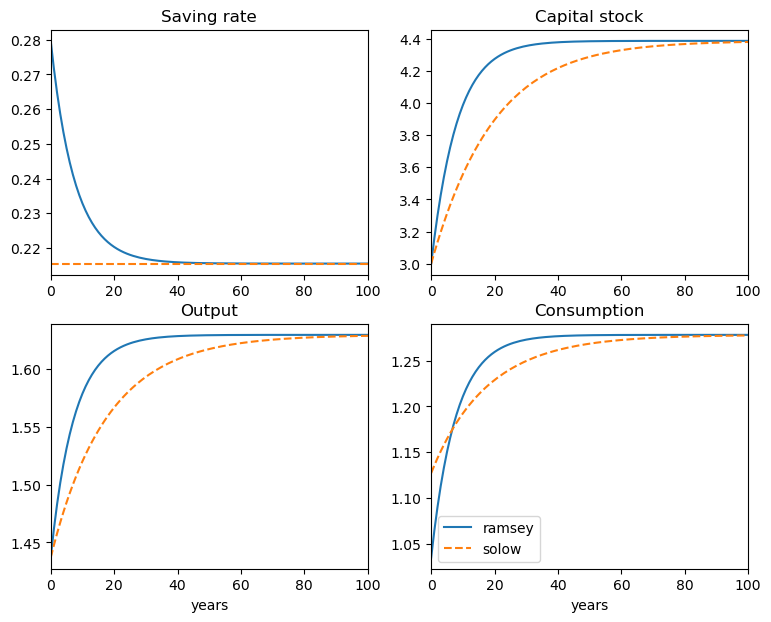

In [7]:
fig, axs = plt.subplots(2,2, figsize = (9,7))

axs[0,0].plot(s_path, label = 'ramsey')
axs[0,0].plot(s_path_solow, '--', label = 'solow')
axs[0,0].set_xlim([0,100])
axs[0,0].set_title('Saving rate')

axs[0,1].plot(k_path, label = 'ramsey')
axs[0,1].plot(k_path_solow, '--', label = 'solow')
axs[0,1].set_xlim([0,100])
axs[0,1].set_title('Capital stock')

axs[1,0].plot(f(k_path), label = 'ramsey')
axs[1,0].plot(f(k_path_solow), '--', label = 'solow')
axs[1,0].set_xlim([0,100])
axs[1,0].set_title('Output')
axs[1,0].set_xlabel('years')

axs[1,1].plot(c_path, label = 'ramsey')
axs[1,1].plot(c_path_solow, '--', label = 'solow')
axs[1,1].set_xlim([0,100])
axs[1,1].set_title('Consumption')
axs[1,1].set_xlabel('years')
axs[1,1].legend()

plt.show()

Note in particular that the Ramsey model implies faster convergence than the Solow model. We saw that already the Solow model gave too fast convergence compared to the evidence, and this mismatch with the empirics is only aggravated once we allow for optimal savings behavior.